
# Time Series Forecasting with Feedforward NN vs. LSTM/GRU (Stocks)



## 1) Setup

In [1]:
import os
import math
import random
import warnings
from dataclasses import dataclass
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Using device: cuda


## 2) Load data (Yahoo Finance with safe fallback)

In [2]:

import datetime as dt

TICKER = "AAPL"
START = "2020-01-01"
END   = "2024-12-31"
PRICE_COL = "Close"

def load_stock_prices(ticker=TICKER, start=START, end=END, price_col=PRICE_COL):
    """Try fetching with yfinance; if it fails, synthesize an ARMA-like series."""
    try:
        import yfinance as yf
        df = yf.download(ticker, start=start, end=end, progress=False)
        if df is None or df.empty:
            raise RuntimeError("Empty dataframe from yfinance.")
        df = df[[price_col]].dropna().rename(columns={price_col: "price"})
        df.index = pd.to_datetime(df.index)
        df.reset_index(inplace=True)
        df.rename(columns={"Date": "date"}, inplace=True)
        src = f"Yahoo Finance ({ticker})"
    except Exception as e:
        print("yfinance failed or offline. Using synthetic fallback. Error:", e)
        # Synthetic AR(1) + trend + seasonality
        n = 1200
        rng = pd.date_range("2020-01-01", periods=n, freq="B")
        eps = np.random.normal(scale=1.0, size=n)
        x = np.zeros(n)
        phi = 0.85
        for t in range(1, n):
            x[t] = phi * x[t-1] + eps[t]
        trend = np.linspace(0, 50, n)
        season = 5*np.sin(np.linspace(0, 20*np.pi, n))
        series = 150 + trend + season + x
        df = pd.DataFrame({"date": rng, "price": series})
        src = "Synthetic AR(1)+trend+seasonality"
    return df, src

df, source = load_stock_prices()
print("Data source:", source)
df.head()


Data source: Yahoo Finance (AAPL)


Price,date,price
Ticker,,AAPL
0,2020-01-02,72.538513
1,2020-01-03,71.833290
2,2020-01-06,72.405670
3,2020-01-07,72.065155
4,2020-01-08,73.224388


## 3) Quick EDA

Price                            date        price
Ticker                                        AAPL
count                            1257  1257.000000
mean    2022-06-30 22:13:27.637231616   151.728301
min               2020-01-02 00:00:00    54.316929
25%               2021-04-01 00:00:00   126.607033
50%               2022-06-30 00:00:00   150.366379
75%               2023-09-29 00:00:00   176.243698
max               2024-12-30 00:00:00   258.103729
std                               NaN    41.896383

Date range: 2020-01-02 → 2024-12-30


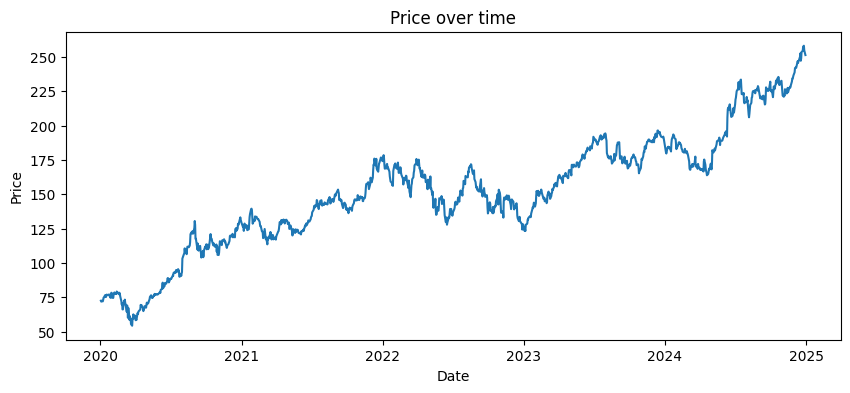

In [3]:

print(df.describe())
print("\nDate range:", df['date'].min().date(), "→", df['date'].max().date())
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['price'])
plt.title("Price over time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


## 4) Windowing utilities (lagged windows → next value)

In [4]:

@dataclass
class WindowConfig:
    seq_len: int = 60           # length of input window
    horizon: int = 1            # predict t+1
    stride: int = 1             # move 1 step
    train_ratio: float = 0.7
    val_ratio: float   = 0.15   # test = 1 - train - val

def make_windows(series: np.ndarray, cfg: WindowConfig):
    X, y = [], []
    for i in range(0, len(series) - cfg.seq_len - cfg.horizon + 1, cfg.stride):
        X.append(series[i:i+cfg.seq_len])
        y.append(series[i+cfg.seq_len:i+cfg.seq_len+cfg.horizon])
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.float32).squeeze()
    return X, y

def time_split(X, y, cfg: WindowConfig):
    n = len(X)
    n_train = int(n * cfg.train_ratio)
    n_val   = int(n * cfg.val_ratio)
    X_train, y_train = X[:n_train], y[:n_train]
    X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


## 5) Scale, build datasets & loaders

In [5]:

cfg = WindowConfig(seq_len=60, horizon=1, stride=1)

# Use only price as univariate series
series = df['price'].values.reshape(-1, 1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series).flatten()

X, y = make_windows(series_scaled, cfg)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = time_split(X, y, cfg)

class SeqDataset(Dataset):
    def __init__(self, X, y, rnn: bool):
        self.X = X
        self.y = y
        self.rnn = rnn
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        if self.rnn:
            # shape (seq_len, 1)
            x = x.reshape(-1, 1)
        else:
            # flatten for FFN
            x = x.reshape(-1)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

BATCH = 128
train_ffn = DataLoader(SeqDataset(X_train, y_train, rnn=False), batch_size=BATCH, shuffle=True)
val_ffn   = DataLoader(SeqDataset(X_val,   y_val,   rnn=False), batch_size=BATCH, shuffle=False)
test_ffn  = DataLoader(SeqDataset(X_test,  y_test,  rnn=False), batch_size=BATCH, shuffle=False)

train_rnn = DataLoader(SeqDataset(X_train, y_train, rnn=True), batch_size=BATCH, shuffle=True)
val_rnn   = DataLoader(SeqDataset(X_val,   y_val,   rnn=True), batch_size=BATCH, shuffle=False)
test_rnn  = DataLoader(SeqDataset(X_test,  y_test,  rnn=True), batch_size=BATCH, shuffle=False)

len(X_train), len(X_val), len(X_test)


(837, 179, 181)

## 6) Models: FFN vs LSTM

In [6]:

class FFN(nn.Module):
    def __init__(self, seq_len, hidden=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x):
        # x: (B, seq_len)
        return self.net(x).squeeze(-1)

class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.2, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=0.0 if num_layers==1 else dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*(2 if bidirectional else 1), 1)
    def forward(self, x):
        # x: (B, T, 1)
        out, (h, c) = self.lstm(x)
        last = out[:, -1, :]  # last timestep
        last = self.dropout(last)
        return self.fc(last).squeeze(-1)

class GRURegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.2, bidirectional=False):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=bidirectional, dropout=0.0 if num_layers==1 else dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*(2 if bidirectional else 1), 1)
    def forward(self, x):
        out, h = self.gru(x)
        last = out[:, -1, :]
        last = self.dropout(last)
        return self.fc(last).squeeze(-1)


## 7) Training utilities

In [7]:

@dataclass
class TrainConfig:
    epochs: int = 20
    lr: float = 1e-3
    weight_decay: float = 1e-5
    patience: int = 5   # early stopping
    model_type: str = "FFN"  # "FFN" | "LSTM" | "GRU"

def train_model(model, loaders, cfg: TrainConfig):
    criterion = nn.L1Loss()  # MAE as optimization target
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_val = float("inf")
    best_state = None
    history = {"train_loss": [], "val_loss": []}
    patience_left = cfg.patience

    for epoch in range(1, cfg.epochs+1):
        # Train
        model.train()
        train_losses = []
        for xb, yb in loaders["train"]:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        train_loss = float(np.mean(train_losses))

        # Validate
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())
        val_loss = float(np.mean(val_losses))

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        print(f"Epoch {epoch:02d} | train MAE: {train_loss:.5f} | val MAE: {val_loss:.5f}")

        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_left = cfg.patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

def evaluate_model(model, loader):
    model.eval()
    preds_all, y_all = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            pred = model(xb).cpu().numpy()
            preds_all.append(pred)
            y_all.append(yb.numpy())
    preds_all = np.concatenate(preds_all)
    y_all = np.concatenate(y_all)
    mae = mean_absolute_error(y_all, preds_all)
    return mae, preds_all, y_all


## 8) Train Feedforward NN

In [8]:

ffn = FFN(seq_len=cfg.seq_len, hidden=128, dropout=0.2).to(DEVICE)
ffn_cfg = TrainConfig(epochs=25, lr=1e-3, weight_decay=1e-6, patience=5, model_type="FFN")

loaders_ffn = {"train": train_ffn, "val": val_ffn}
ffn, hist_ffn = train_model(ffn, loaders_ffn, ffn_cfg)

ffn_mae_test, ffn_pred, ffn_true = evaluate_model(ffn, test_ffn)
print("FFN Test MAE:", round(ffn_mae_test, 6))


Epoch 01 | train MAE: 0.30735 | val MAE: 0.09265
Epoch 02 | train MAE: 0.09933 | val MAE: 0.07889
Epoch 03 | train MAE: 0.07154 | val MAE: 0.03158
Epoch 04 | train MAE: 0.05735 | val MAE: 0.11722
Epoch 05 | train MAE: 0.05429 | val MAE: 0.03086
Epoch 06 | train MAE: 0.04851 | val MAE: 0.05619
Epoch 07 | train MAE: 0.04606 | val MAE: 0.02973
Epoch 08 | train MAE: 0.04635 | val MAE: 0.03195
Epoch 09 | train MAE: 0.04346 | val MAE: 0.03197
Epoch 10 | train MAE: 0.04137 | val MAE: 0.02711
Epoch 11 | train MAE: 0.04080 | val MAE: 0.02437
Epoch 12 | train MAE: 0.03876 | val MAE: 0.02656
Epoch 13 | train MAE: 0.03589 | val MAE: 0.02869
Epoch 14 | train MAE: 0.03596 | val MAE: 0.02433
Epoch 15 | train MAE: 0.03463 | val MAE: 0.02056
Epoch 16 | train MAE: 0.03461 | val MAE: 0.01993
Epoch 17 | train MAE: 0.03485 | val MAE: 0.01975
Epoch 18 | train MAE: 0.03316 | val MAE: 0.02755
Epoch 19 | train MAE: 0.03251 | val MAE: 0.02711
Epoch 20 | train MAE: 0.03070 | val MAE: 0.02865
Epoch 21 | train MAE

## 9) Train LSTM

In [9]:

lstm = LSTMRegressor(input_size=1, hidden_size=64, num_layers=1, dropout=0.2, bidirectional=False).to(DEVICE)
lstm_cfg = TrainConfig(epochs=25, lr=1e-3, weight_decay=1e-6, patience=5, model_type="LSTM")

loaders_rnn = {"train": train_rnn, "val": val_rnn}
lstm, hist_lstm = train_model(lstm, loaders_rnn, lstm_cfg)

lstm_mae_test, lstm_pred, lstm_true = evaluate_model(lstm, test_rnn)
print("LSTM Test MAE:", round(lstm_mae_test, 6))


Epoch 01 | train MAE: 0.37082 | val MAE: 0.50667
Epoch 02 | train MAE: 0.27002 | val MAE: 0.37299
Epoch 03 | train MAE: 0.14565 | val MAE: 0.10497
Epoch 04 | train MAE: 0.11437 | val MAE: 0.13867
Epoch 05 | train MAE: 0.09937 | val MAE: 0.20715
Epoch 06 | train MAE: 0.09647 | val MAE: 0.14699
Epoch 07 | train MAE: 0.08946 | val MAE: 0.11400
Epoch 08 | train MAE: 0.08773 | val MAE: 0.15310
Early stopping.
LSTM Test MAE: 0.256782


In [10]:

TRAIN_GRU = False  # set True to also train GRU

gru_mae_test = None
gru_pred = None
gru_true = None

if TRAIN_GRU:
    gru = GRURegressor(input_size=1, hidden_size=64, num_layers=1, dropout=0.2, bidirectional=False).to(DEVICE)
    gru_cfg = TrainConfig(epochs=25, lr=1e-3, weight_decay=1e-6, patience=5, model_type="GRU")
    gru, hist_gru = train_model(gru, loaders_rnn, gru_cfg)
    gru_mae_test, gru_pred, gru_true = evaluate_model(gru, test_rnn)
    print("GRU Test MAE:", round(gru_mae_test, 6))


## 10) Inverse-transform predictions for interpretability

In [11]:

def invert_scale(arr_1d):
    arr_2d = np.array(arr_1d).reshape(-1, 1)
    return scaler.inverse_transform(arr_2d).reshape(-1)

ffn_pred_raw  = invert_scale(ffn_pred)
ffn_true_raw  = invert_scale(ffn_true)
lstm_pred_raw = invert_scale(lstm_pred)
lstm_true_raw = invert_scale(lstm_true)

if gru_pred is not None:
    gru_pred_raw = invert_scale(gru_pred)
    gru_true_raw = invert_scale(gru_true)

print("Sample (actual, ffn_pred, lstm_pred):")
list(zip(ffn_true_raw[:5], ffn_pred_raw[:5], lstm_pred_raw[:5]))


Sample (actual, ffn_pred, lstm_pred):


[(np.float32(175.2912), np.float32(168.10297), np.float32(155.68141)),
 (np.float32(171.45871), np.float32(168.60141), np.float32(155.95691)),
 (np.float32(168.17232), np.float32(168.92477), np.float32(155.9882)),
 (np.float32(166.80215), np.float32(168.48354), np.float32(155.85579)),
 (np.float32(165.849), np.float32(167.1636), np.float32(155.6891))]

## 11) Plots: Predicted vs Actual (Test set)

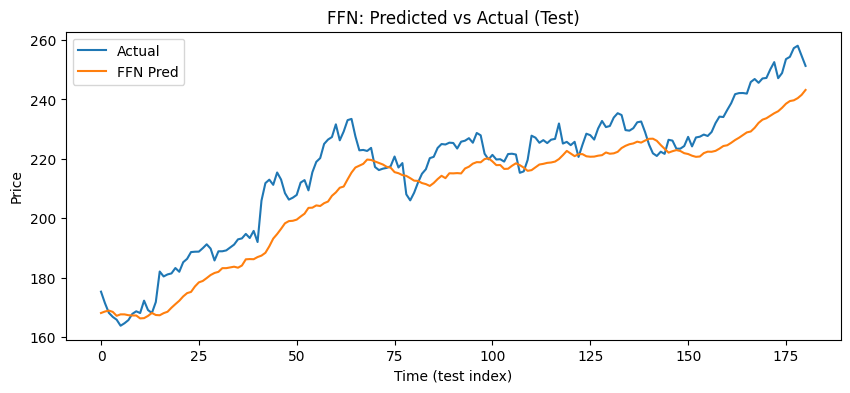

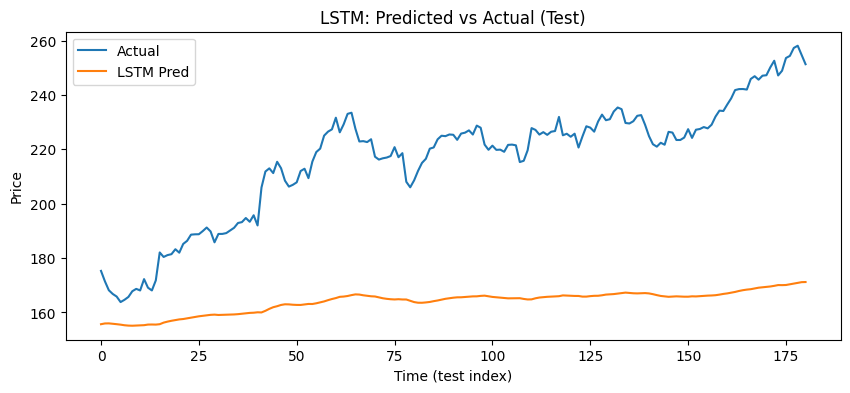

In [12]:

plt.figure(figsize=(10,4))
plt.plot(ffn_true_raw, label="Actual")
plt.plot(ffn_pred_raw, label="FFN Pred")
plt.title("FFN: Predicted vs Actual (Test)")
plt.xlabel("Time (test index)")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(lstm_true_raw, label="Actual")
plt.plot(lstm_pred_raw, label="LSTM Pred")
plt.title("LSTM: Predicted vs Actual (Test)")
plt.xlabel("Time (test index)")
plt.ylabel("Price")
plt.legend()
plt.show()

if gru_mae_test is not None:
    plt.figure(figsize=(10,4))
    plt.plot(gru_true_raw, label="Actual")
    plt.plot(gru_pred_raw, label="GRU Pred")
    plt.title("GRU: Predicted vs Actual (Test)")
    plt.xlabel("Time (test index)")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


## 12) Compare MAE

In [13]:

rows = [("FFN", ffn_mae_test)]
rows.append(("LSTM", lstm_mae_test))
if gru_mae_test is not None:
    rows.append(("GRU", gru_mae_test))

df_scores = pd.DataFrame(rows, columns=["Model", "Test MAE (scaled)"])
print(df_scores)

# Also compute MAE on de-normalized scale for clearer interpretation (using overlapping true series)
def mae_raw(true_raw, pred_raw):
    return float(np.mean(np.abs(true_raw - pred_raw)))

raw_rows = [("FFN", mae_raw(ffn_true_raw, ffn_pred_raw)),
            ("LSTM", mae_raw(lstm_true_raw, lstm_pred_raw))]
if gru_mae_test is not None:
    raw_rows.append(("GRU", mae_raw(gru_true_raw, gru_pred_raw)))

df_scores_raw = pd.DataFrame(raw_rows, columns=["Model", "Test MAE (original price units)"])
print("\n", df_scores_raw)


  Model  Test MAE (scaled)
0   FFN           0.041140
1  LSTM           0.256782

   Model  Test MAE (original price units)
0   FFN                         8.383717
1  LSTM                        52.328773


## 13) Quick sequence-length sweep (small demo)

In [14]:

def quick_eval_for_seq_len(seq_len: int) -> Dict[str, float]:
    local_cfg = WindowConfig(seq_len=seq_len, horizon=1, stride=1, train_ratio=cfg.train_ratio, val_ratio=cfg.val_ratio)
    X2, y2 = make_windows(series_scaled, local_cfg)
    (X2tr, y2tr), (X2v, y2v), (X2te, y2te) = time_split(X2, y2, local_cfg)

    # RNN loader (use LSTM)
    tr = DataLoader(SeqDataset(X2tr, y2tr, rnn=True), batch_size=BATCH, shuffle=True)
    va = DataLoader(SeqDataset(X2v, y2v, rnn=True), batch_size=BATCH, shuffle=False)
    te = DataLoader(SeqDataset(X2te, y2te, rnn=True), batch_size=BATCH, shuffle=False)

    model = LSTMRegressor(input_size=1, hidden_size=64, num_layers=1, dropout=0.2, bidirectional=False).to(DEVICE)
    tc = TrainConfig(epochs=10, lr=1e-3, weight_decay=1e-6, patience=3, model_type="LSTM")
    model, _ = train_model(model, {"train": tr, "val": va}, tc)
    mae_scaled, _, _ = evaluate_model(model, te)
    return {"seq_len": seq_len, "mae_scaled": mae_scaled}

seq_lengths = [10, 20, 60]
results = [quick_eval_for_seq_len(L) for L in seq_lengths]
pd.DataFrame(results)


Epoch 01 | train MAE: 0.36756 | val MAE: 0.53838
Epoch 02 | train MAE: 0.26389 | val MAE: 0.40024
Epoch 03 | train MAE: 0.14994 | val MAE: 0.16193
Epoch 04 | train MAE: 0.12097 | val MAE: 0.12294
Epoch 05 | train MAE: 0.10578 | val MAE: 0.22441
Epoch 06 | train MAE: 0.10828 | val MAE: 0.19265
Epoch 07 | train MAE: 0.09684 | val MAE: 0.12506
Early stopping.
Epoch 01 | train MAE: 0.27524 | val MAE: 0.41544
Epoch 02 | train MAE: 0.17083 | val MAE: 0.23423
Epoch 03 | train MAE: 0.11604 | val MAE: 0.11404
Epoch 04 | train MAE: 0.10669 | val MAE: 0.20507
Epoch 05 | train MAE: 0.10409 | val MAE: 0.19265
Epoch 06 | train MAE: 0.09809 | val MAE: 0.14040
Early stopping.
Epoch 01 | train MAE: 0.43744 | val MAE: 0.57820
Epoch 02 | train MAE: 0.32113 | val MAE: 0.43098
Epoch 03 | train MAE: 0.16787 | val MAE: 0.11045
Epoch 04 | train MAE: 0.12620 | val MAE: 0.16325
Epoch 05 | train MAE: 0.10293 | val MAE: 0.22556
Epoch 06 | train MAE: 0.10176 | val MAE: 0.15746
Early stopping.


,seq_len,mae_scaled
0,10,0.258767
1,20,0.256091
2,60,0.270822
